In [10]:
import findspark

findspark.init()

import os
import sys
from pyspark.rdd import RDD
from pyspark.sql import Row
from pyspark.sql import DataFrame
from pyspark.sql import SparkSession
from pyspark.sql.functions import lit
from pyspark.sql.functions import desc
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.recommendation import ALS
from pyspark.sql.functions import when, lit, col
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
#from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold
from pyspark.ml.recommendation import ALS, ALSModel
### ALSModel.load("modelSaveOut")

In [2]:
def init_spark():
    spark = SparkSession \
        .builder \
        .appName("Python Spark SQL Pipeline Recommender") \
        .config("spark.some.config.option", "some-value") \
        .getOrCreate()
    return spark

spark = init_spark()


In [3]:
fold_num = 10

kf = KFold(n_splits=fold_num,shuffle=True)
df = pd.read_csv('pairs_main.csv')
print(kf.split(df))

<generator object _BaseKFold.split at 0x000001CDA2C35E58>


In [4]:
als = ALS(maxIter=5, regParam=0.01, userCol="pipeline", itemCol="dataset",ratingCol="status", coldStartStrategy="drop", rank=10, seed=2020)


In [5]:
allFolds = []
for k in range (fold_num):
    result = next(kf.split(df), None)
    allFolds.append(result)
    #print(result[1])




In [6]:
#thre_TPR_FPR = pd.DataFrame(columns = ['threshold','avg_TPR','avg_FPR'])


In [7]:
def TPR_FPR(predictions):
    Posetive_class2 = predictions[predictions['status'] == 2]
    Negative_class1 = predictions[predictions['status'] == 1]
    TP_df = predictions[(predictions['status'] == 2) & (predictions['pred_class'] == 2)]
    FP_df = predictions[(predictions['status'] == 1) & (predictions['pred_class'] == 2)]
    TN_df = predictions[(predictions['status'] == 1) & (predictions['pred_class'] == 1)]
    FN_df = predictions[(predictions['status'] == 2) & (predictions['pred_class'] == 1)]

    TPR = TP_df.shape[0]/Posetive_class2.shape[0]
    FPR = FP_df.shape[0]/Negative_class1.shape[0]
    return TPR,FPR

In [8]:
def allThresholds(allFoldsPredictions):#,minTh,maxTh):
    thre_TPR_FPR = pd.DataFrame(columns = ['threshold','avg_TPR','avg_FPR'])

    all_avg_TPR = []
    all_avg_FPR = []
    i = 0
    for threshold in np.arange(-0.1,2.4,0.1):
        TPR_list = []
        FPR_list = []
        for predictions in allFoldsPredictions:  #add pred_class column to predictions DF
            #classifiedDF = predictions.withColumn("pred_class", when(col("prediction") >= threshold ,lit(2)).otherwise(lit(1)))
            predictions.loc[predictions['prediction'] <= threshold, 'pred_class'] = 1 
            predictions.loc[predictions['prediction'] > threshold, 'pred_class'] = 2
            
            TPR,FPR = TPR_FPR(predictions)
            TPR_list.append(TPR)
            FPR_list.append(FPR)
        avg_TPR = sum(TPR_list)/len(TPR_list)
        all_avg_TPR.append(avg_TPR)
        avg_FPR = sum(FPR_list)/len(FPR_list)
        all_avg_FPR.append(avg_FPR)
        print("threshold", threshold,"avg_TPR",avg_TPR,"avg_FPR: ",avg_FPR)
        #thre_TPR_FPR = thre_TPR_FPR.append({'threshold':threshold,'avg_TPR': avg_TPR ,'avg_FPR': avg_FPR}, ignore_index = True)
        
    return all_avg_TPR,all_avg_FPR

In [34]:
column_names = "pipeline|dataset|status|prediction" 

all_appended_predictions = spark.createDataFrame(
  [
    tuple('' for i in column_names.split("|"))
  ],
  column_names.split("|")
).where("1=0")

all_appended_predictions.show()

+--------+-------+------+----------+
|pipeline|dataset|status|prediction|
+--------+-------+------+----------+
+--------+-------+------+----------+



In [9]:
#base = 1
#for threshold in np.arange(0.5,2.5,0.1):
allFoldsPredictions = []
list_pd_allFoldsPredictions = []

pd.concat
#all_appended_predictions = spark.createDataFrame(['pipeline','dataset','status','prediction'])   #(pd.DataFrame(columns =['pipeline','dataset','status','prediction']))
#threshold = 1.5

#step = (i/10)
#threshold = base + step 
for k in range (fold_num):
    result = allFolds[k]
    #result = next(kf.split(df), None)
#print (result)

    train = df.iloc[result[0]]
    test =  df.iloc[result[1]]
    spark_train = spark.createDataFrame(train)
    spark_test = spark.createDataFrame(test)
    #print(type(test))
    model = als.fit(spark_train)
    predictions = model.transform(spark_test)
    pd_predictions = predictions.toPandas()
    #all_appended_predictions = all_appended_predictions.union(predictions)
    print("round ",k)
      
    predictions.show(5, truncate=True)
    pd_predictions[:5]
    list_pd_allFoldsPredictions.append(pd_predictions)
    #classifiedDF = predictions.withColumn("pred_class", when(col("prediction") >= threshold ,lit(2)).otherwise(lit(1)))
    #print("min pred in ",k," : ")
    #minPred = min(predictions.select(min('prediction')))#agg({'prediction': 'min'}),minPred)
    #print("max pred in ",k," : ")
    #classifiedDF.agg({'prediction': 'max'}).show()
    #maxPred = max(predictions.agg({'prediction': 'max'}),maxPred)



concat_list_pd_allFoldsPredictions = pd.concat(list_pd_allFoldsPredictions)



####write to DF or CSV then read from that



round  0
+--------+-------+------+----------+
|pipeline|dataset|status|prediction|
+--------+-------+------+----------+
|      31|      1|     1| 0.3837454|
|      28|      1|     1| 0.5353072|
|      24|     13|     2| 1.8534912|
|       4|      6|     1|0.77039564|
|      12|     16|     2| 1.2579799|
+--------+-------+------+----------+
only showing top 5 rows

round  1
+--------+-------+------+----------+
|pipeline|dataset|status|prediction|
+--------+-------+------+----------+
|       7|     12|     1| 1.0109104|
|      14|     12|     1|0.83291256|
|      21|      1|     1|0.66735977|
|      26|     13|     2| 1.8319668|
|      14|     13|     2|0.96535176|
+--------+-------+------+----------+
only showing top 5 rows

round  2
+--------+-------+------+----------+
|pipeline|dataset|status|prediction|
+--------+-------+------+----------+
|       3|     12|     1|0.62086886|
|      16|     13|     2| 2.0804346|
|       4|     13|     1| 1.1109697|
|       7|     13|     2|  2.148474

In [1]:
#model.save("C:\Concordia_University\Thesis\coding\recommender_codes\als_spark\myModel")

In [2]:
#model.productFeatures()

In [43]:
#all_appended_predictions.write.csv('C:\Concordia_University\Thesis\coding\recommender_codes\als_spark\all_predictons.csv')
#all_appended_predictions.show(25, truncate=True)
#panda_all_appended_predictions = all_appended_predictions.select("*").toPandas()

In [10]:
#panda_all_appended_predictions.to_csv('all_predictons.csv')
concat_list_pd_allFoldsPredictions.to_csv('concat_pd_all_predictons.csv')

In [13]:
#minPred = panda_all_appended_predictions['prediction'].min()
#maxPred = panda_all_appended_predictions['prediction'].max()
minPred = concat_list_pd_allFoldsPredictions['prediction'].min()
maxPred = concat_list_pd_allFoldsPredictions['prediction'].max()
print(minPred)
print(maxPred)

-0.006543159484863281
2.369220495223999


In [15]:
all_avg_TPR,all_avg_FPR = allThresholds(list_pd_allFoldsPredictions)#,minPred,maxPred)

threshold -0.1 avg_TPR 1.0 avg_FPR:  1.0
threshold 0.0 avg_TPR 0.9941176470588236 avg_FPR:  1.0
threshold 0.1 avg_TPR 0.9869747899159664 avg_FPR:  0.99375
threshold 0.20000000000000004 avg_TPR 0.9769747899159664 avg_FPR:  0.99375
threshold 0.30000000000000004 avg_TPR 0.9769747899159664 avg_FPR:  0.9760808270676691
threshold 0.4 avg_TPR 0.9769747899159664 avg_FPR:  0.968937969924812
threshold 0.5000000000000001 avg_TPR 0.9534001292824822 avg_FPR:  0.9543546365914788
threshold 0.6000000000000001 avg_TPR 0.9534001292824822 avg_FPR:  0.9090432812801235
threshold 0.7000000000000001 avg_TPR 0.9534001292824822 avg_FPR:  0.8493231098107259
threshold 0.8 avg_TPR 0.9371501292824822 avg_FPR:  0.8024487548055659
threshold 0.9 avg_TPR 0.8965455541190834 avg_FPR:  0.681940215357398
threshold 1.0 avg_TPR 0.8569905013287367 avg_FPR:  0.45224609884439604
threshold 1.1 avg_TPR 0.7998581483875601 avg_FPR:  0.3019091280236791
threshold 1.2 avg_TPR 0.750956690368455 avg_FPR:  0.23908080438653193
threshold 

In [22]:
def resultFromFile():
    TPR_FPR_results = pd.read_csv('thre_tpr_fpr.csv')

    TPR_list = TPR_FPR_results['TPR_avg'].values.tolist() # => [1, 2, 3, 4]
    FPR_list = TPR_FPR_results['FPR_avg'].values.tolist()
    return(TPR_list,FPR_list)

In [23]:
TPR_list,FPR_list = resultFromFile()

In [12]:
TPR_list = thre_TPR_FPR['avg_TPR'].values.tolist() # => [1, 2, 3, 4]
FPR_list = thre_TPR_FPR['avg_FPR'].values.tolist()
print(TPR_list)

[]


In [ ]:
print

No handles with labels found to put in legend.


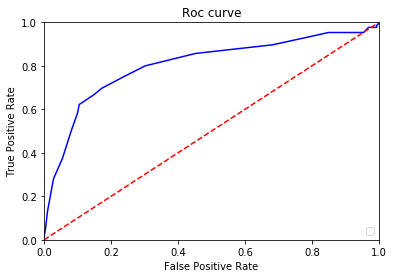

<Figure size 432x288 with 0 Axes>

In [16]:
plt.title('Roc curve')
plt.plot(all_avg_FPR,all_avg_TPR, 'b')#, label='AUC = %0.2f')# % roc_auc)
plt.legend(loc='lower right')
plt.plot([0, 1], [0, 1], 'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()
plt.savefig('thre_1-2.png')


In [17]:
AUC = 0
for i in range(len(all_avg_TPR)-1):
    AUC = AUC + (((all_avg_TPR[i]+all_avg_TPR[i+1])/2) * (all_avg_FPR[i]-all_avg_FPR[i+1]))
print(AUC)   


0.8045637525713133
